In [ ]:
# 라이브러리를 아는대로 끌어모아보았습니다.
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from matplotlib import font_manager, rc

In [ ]:
# 파일 불러오기
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv", encoding = 'cp949')
submission = pd.read_csv("/content/sample_submission.csv", encoding = 'cp949')

In [ ]:
# 행과 열 확인
print(train.shape, test.shape) # test에서의 중식계와 석식계는 submission에 있습니다.

(1205, 12) (50, 10)


In [ ]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴
0,2021/01/27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치
1,2021/01/28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지
2,2021/01/29,금,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치
3,2021/02/01,월,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치
4,2021/02/02,화,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치


In [ ]:
submission.head()

,일자,중식계,석식계
0,2021/01/27,0,0
1,2021/01/28,0,0
2,2021/01/29,0,0
3,2021/02/01,0,0
4,2021/02/02,0,0


In [ ]:
train.info()
print("")
test.info()
print("")
submission.info() # 결측값이 발견되지 않음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              1205 non-null   object 
 1   요일              1205 non-null   object 
 2   본사정원수           1205 non-null   int64  
 3   본사휴가자수          1205 non-null   int64  
 4   본사출장자수          1205 non-null   int64  
 5   본사시간외근무명령서승인건수  1205 non-null   int64  
 6   현본사소속재택근무자수     1205 non-null   float64
 7   조식메뉴            1205 non-null   object 
 8   중식메뉴            1205 non-null   object 
 9   석식메뉴            1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 113.1+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   일자

In [ ]:
# 우연히 확인해본 결과 2018년 6월 1일 요일이 이상하게 표기됨. 올바르게 금요일로 바꿈.
day_miss = train[train['일자'].str.contains('2018-06-01')].index
train.loc[day_miss[0], '요일'] = '금'

In [ ]:
# 요일 자체가 식수인원에 영향을 줄 것 같다는 추측에 요일을 쪼갬
def split_week(df) :
  df["월"] = 0
  df["화"] = 0
  df["수"] = 0
  df["목"] = 0
  df["금"] = 0
  file_shape = df.shape
  file_shape_list = list(df.shape) 
  for i in range(0, file_shape_list[0]) :
    if df["요일"].iloc[i] == "월" :
      df["월"].iloc[i] += 1
    elif df["요일"].iloc[i] == "화" :
      df["화"].iloc[i] += 1
    elif df["요일"].iloc[i] == "수" :
      df["수"].iloc[i] += 1
    elif df["요일"].iloc[i] == "목" :
      df["목"].iloc[i] += 1
    else :
      df["금"].iloc[i] += 1
split_week(train)
split_week(test)
train.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,0,0,0,0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0,1,0,0,0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0,0,1,0,0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,0,0,0,1,0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,0,0,0,0,1


In [ ]:
test.head()

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,월,화,수,목,금
0,2021/01/27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,0,0,1,0,0
1,2021/01/28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,0,0,0,1,0
2,2021/01/29,금,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,0,0,0,0,1
3,2021/02/01,월,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,1,0,0,0,0
4,2021/02/02,화,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,0,1,0,0,0


In [ ]:
# 열 네임들이 너무 장황해서 간단하게 수정
train.rename(columns={'본사정원수':'정원',
                      '본사휴가자수':'휴가',
                      '본사출장자수':'출장',
                      '본사시간외근무명령서승인건수':'야근',
                      '현본사소속재택근무자수':'본사재택'},
             inplace=True)

test.rename(columns={'본사정원수':'정원',
                     '본사휴가자수':'휴가',
                     '본사출장자수':'출장',
                     '본사시간외근무명령서승인건수':'야근',
                     '현본사소속재택근무자수':'본사재택'},
            inplace=True)
train.info()
print("")
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일자      1205 non-null   object 
 1   요일      1205 non-null   object 
 2   정원      1205 non-null   int64  
 3   휴가      1205 non-null   int64  
 4   출장      1205 non-null   int64  
 5   야근      1205 non-null   int64  
 6   본사재택    1205 non-null   float64
 7   조식메뉴    1205 non-null   object 
 8   중식메뉴    1205 non-null   object 
 9   석식메뉴    1205 non-null   object 
 10  중식계     1205 non-null   float64
 11  석식계     1205 non-null   float64
 12  월       1205 non-null   int64  
 13  화       1205 non-null   int64  
 14  수       1205 non-null   int64  
 15  목       1205 non-null   int64  
 16  금       1205 non-null   int64  
dtypes: float64(3), int64(9), object(5)
memory usage: 160.2+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 15 columns):
 #   Column  Non-Null 

In [ ]:
train.head()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,0,0,0,0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0,1,0,0,0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0,0,1,0,0
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,0,0,0,1,0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,0,0,0,0,1


In [ ]:
test.tail()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,월,화,수,목,금
45,2021/04/05,월,2973,125,174,704,331,모닝롤/커피콩빵 우유/주스 계란후라이 누룽지탕/흑미밥 청양콩나물국 스팸구이 양상추샐...,쌀밥/흑미밥/찰현미밥 쇠고기미역국 춘천닭갈비 오지치즈후라이 가지두반장볶음 포기김치 ...,흑미밥 돈육고추장찌개 갈치구이 김치전 취나물무침 깍두기,1,0,0,0,0
46,2021/04/06,화,2973,76,170,636,364,모닝롤/모닝샌드 우유/주스 계란후라이 고구마스프/흑미밥 아욱국 참치채소볶음 양상추샐...,쌀밥/귀리밥/찰현미밥 순두부백탕 매콤소갈비찜 깻잎완자전 돌나물초장무침 포기김치 시리...,추가밥 짬뽕*생면 수제찹쌀꿔바로우 메추리알곤약장조림 단무지무침 포기김치,0,1,0,0,0
47,2021/04/07,수,2973,96,214,1,334,모닝롤/호떡맥모닝 우유/주스 계란후라이 팥죽/흑미밥 닭살해장국 우엉채조림 양상추샐러...,쌀밥/흑미밥/찰현미밥 냉이국 돈육간장불고기 비빔냉면 오이나물볶음 겉절이김치 양상추샐...,단호박카레라이스 시금치된장국 소떡소떡 파프리카해초무침 감귤쥬스 포기김치,0,0,1,0,0
48,2021/04/08,목,2973,105,238,509,324,모닝롤/크로크무슈 우유/주스 계란후라이 누룽지탕/흑미밥 감자국 두부양념조림 양상추샐...,쌀밥/옥수수밥/찰현미밥 맑은떡국 (New)로제찜닭 가자미구이*장 유채나물무침 포기김...,흑미밥 어묵매운탕 쇠고기숙주볶음 채소계란찜 쑥갓생무침 김치볶음,0,0,0,1,0
49,2021/04/09,금,2973,259,268,0,229,모닝롤/토마토샌드 우유/주스 계란후라이 채소죽/흑미밥 대구지리 애호박나물볶음 양상추...,쌀밥/흑미밥/찰현미밥 사골우거지국 해물누룽지탕 청포묵*양념간장 비름나물고추장무침 석...,흑미밥 맑은버섯국 매운사태조림 춘권*타르타르D 열무나물무침 포기김치,0,0,0,0,1


In [ ]:
# 휴일과 휴일의 양이 식수인원에 영향을 미칠 것 같다는 추측에 휴일 정보 생성
def set_holiday_future(df) :
  df["예정 휴일"] = 0
  for i in range(0, df.shape[0]-1) :
    if df["요일"].iloc[i] == "월" :
      if df["요일"].iloc[i+1] == "수" :
        df["예정 휴일"].iloc[i] += 1
      elif df["요일"].iloc[i+1] == "목" :
        df["예정 휴일"].iloc[i] += 2
      elif df["요일"].iloc[i+1] == "금" :
        df["예정 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i+1] == "월" :
        df["예정 휴일"].iloc[i] += 6
      else :
        df["예정 휴일"].iloc[i] += 0

    elif df["요일"].iloc[i] == "화" :
      if df["요일"].iloc[i+1] == "목" :
        df["예정 휴일"].iloc[i] += 1
      elif df["요일"].iloc[i+1] == "금" :
        df["예정 휴일"].iloc[i] += 2
      elif df["요일"].iloc[i+1] == "월" :
        df["예정 휴일"].iloc[i] += 5
      elif df["요일"].iloc[i+1] == "화" :
        df["예정 휴일"].iloc[i] += 6
      else :
        df["예정 휴일"].iloc[i] += 0
    
    elif df["요일"].iloc[i] == "수" :
      if df["요일"].iloc[i+1] == "금" :
        df["예정 휴일"].iloc[i] += 1
      elif df["요일"].iloc[i+1] == "월" :
        df["예정 휴일"].iloc[i] += 4
      elif df["요일"].iloc[i+1] == "화" :
        df["예정 휴일"].iloc[i] += 5
      elif df["요일"].iloc[i+1] == "수" :
        df["예정 휴일"].iloc[i] += 6
      else :
        df["예정 휴일"].iloc[i] += 0

    elif df["요일"].iloc[i] == "목" :
      if df["요일"].iloc[i+1] == "금" :
        df["예정 휴일"].iloc[i] += 0
      elif df["요일"].iloc[i+1] == "월" :
        df["예정 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i+1] == "화" :
        df["예정 휴일"].iloc[i] += 4
      elif df["요일"].iloc[i+1] == "수" :
        df["예정 휴일"].iloc[i] += 5
      else :
        df["예정 휴일"].iloc[i] += 6

    elif df["요일"].iloc[i] == "금" :
      if df["요일"].iloc[i+1] == "월" :
        df["예정 휴일"].iloc[i] += 2
      elif df["요일"].iloc[i+1] == "화" :
        df["예정 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i+1] == "수" :
        df["예정 휴일"].iloc[i] += 4
      elif df["요일"].iloc[i+1] == "목" :
        df["예정 휴일"].iloc[i] += 5
      else :
        df["예정 휴일"].iloc[i] += 6

set_holiday_future(test)
set_holiday_future(train)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
def set_holiday_past(df) :
  df["지난 휴일"] = 0
  for i in range(0, df.shape[0]-1) :
    if df["요일"].iloc[i] == "월" :
      if df["요일"].iloc[i-1] == "목" :
        df["지난 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i-1] == "수" :
        df["지난 휴일"].iloc[i] += 4
      elif df["요일"].iloc[i-1] == "화" :
        df["지난 휴일"].iloc[i] += 5
      elif df["요일"].iloc[i-1] == "월" :
        df["지난 휴일"].iloc[i] += 6
      else :
        df["지난 휴일"].iloc[i] += 2

    elif df["요일"].iloc[i] == "화" :
      if df["요일"].iloc[i-1] == "월" :
        df["지난 휴일"].iloc[i] += 0
      elif df["요일"].iloc[i-1] == "금" :
        df["지난 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i-1] == "목" :
        df["지난 휴일"].iloc[i] += 4
      elif df["요일"].iloc[i-1] == "수" :
        df["지난 휴일"].iloc[i] += 5
      else :
        df["지난 휴일"].iloc[i] += 6
    
    elif df["요일"].iloc[i] == "수" :
      if df["요일"].iloc[i-1] == "화" :
        df["지난 휴일"].iloc[i] += 0
      elif df["요일"].iloc[i-1] == "월" :
        df["지난 휴일"].iloc[i] += 1
      elif df["요일"].iloc[i-1] == "금" :
        df["지난 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i-1] == "목" :
        df["지난 휴일"].iloc[i] += 4
      else :
        df["지난 휴일"].iloc[i] += 6

    elif df["요일"].iloc[i] == "목" :
      if df["요일"].iloc[i-1] == "화" :
        df["지난 휴일"].iloc[i] += 1
      elif df["요일"].iloc[i-1] == "월" :
        df["지난 휴일"].iloc[i] += 2
      elif df["요일"].iloc[i-1] == "금" :
        df["지난 휴일"].iloc[i] += 5
      elif df["요일"].iloc[i-1] == "목" :
        df["지난 휴일"].iloc[i] += 6
      else :
        df["지난 휴일"].iloc[i] += 0
    
    elif df["요일"].iloc[i] == "금" :
      if df["요일"].iloc[i-1] == "화" :
        df["지난 휴일"].iloc[i] += 2
      elif df["요일"].iloc[i-1] == "월" :
        df["지난 휴일"].iloc[i] += 3
      elif df["요일"].iloc[i-1] == "금" :
        df["지난 휴일"].iloc[i] += 5
      elif df["요일"].iloc[i-1] == "목" :
        df["지난 휴일"].iloc[i] += 0
      else :
        df["지난 휴일"].iloc[i] += 1
set_holiday_past(test)
set_holiday_past(train)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# 위의 함수처럼 하면 첫 행과 마지막행들이 올바르게 나타나지 않아 이것은 본인이 직접 설정
train["예정 휴일"].iloc[0] = 0
train["지난 휴일"].iloc[0] = 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
test["지난 휴일"].iloc[0] = 0
test["예정 휴일"].iloc[49] = 2

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train.tail()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금,예정 휴일,지난 휴일
1200,2021-01-20,수,2983,75,198,4,391.0,모닝롤/페퍼로니피자 우유/주스 계란후라이/찐계란 크루통크림스프/흑미밥 아귀지리 마늘...,쌀밥/흑미밥/찰현미밥 아욱국 수제함박스테이크 견과류마카로니범벅 생깻잎지 단호박물김치...,김치볶음밥 미니쫄우동*맛살튀김 브로콜리깨소스무침 계란후라이 고들빼기무침 겉절이김치,1093.0,421.0,0,0,1,0,0,0,0
1201,2021-01-21,목,2983,92,231,462,351.0,모닝롤/생크림단팥빵 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 떡국 해물땡굴소스볶...,쌀밥/수수밥/찰현미밥 냉이된장국 동파육 봄동전 청경채/버섯숙회*초장 무생채 양상추샐...,흑미밥 쇠고기무국 삼치양념구이 비엔나채소볶음 숙주나물당근무침 포기김치,832.0,353.0,0,0,0,1,0,0,0
1202,2021-01-22,금,2983,255,248,1,303.0,모닝롤/BLT샌드위치 우유/주스 계란후라이/찐계란 흑임자죽/흑미밥 바지락살국 두부조...,전주비빔밥*약고추장 계란파국 요거닭 올방개묵무침 파프리카해초무침 포기김치 양상추샐러...,흑미밥 수제비국 수제맛쵸킹탕수육 유부채소겨자냉채 참나물무침 갓김치/겉절이김치,579.0,217.0,0,0,0,0,1,2,0
1203,2021-01-25,월,2983,107,153,616,327.0,모닝롤/호박고구마오븐구이 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 감자양파국 분...,쌀밥/흑미밥/찰현미밥 전주식콩나물해장국 돈육간장불고기 깐풍연근 연두부*달래양념장 봄...,흑미밥 열무된장국 장어강정*데리야끼소스 깻잎쌈*생강채 오이선 포기김치,1145.0,502.0,1,0,0,0,0,0,2
1204,2021-01-26,화,2983,69,183,551,362.0,모닝롤/야채샌드 우유/주스 계란후라이/찐계란 참치죽/흑미밥 홍합탕 애호박새우젓볶음 ...,쌀밥/귀리밥/찰현미밥 들깨미역국 교촌간장치킨 옥수수콘치즈구이 가지고추장무침 포기김치...,(New)할라피뇨멸치주먹밥 잔치국수 수제고기육전 쑥갓나물 양파초절임 깍두기,1015.0,480.0,0,1,0,0,0,0,0


In [ ]:
# 막연한 마음에 요일 자체를 숫자로도 분류함 (논리적이라고 할 수 없는 판단이긴함)
def change_day_num(df) :
  df["요일_num"] = 0
  for i in range(df.shape[0]-1) :
    if df["요일"].iloc[i] == "월" :
      df["요일_num"].iloc[i] = 1
    elif df["요일"].iloc[i] == "화" :
      df["요일_num"].iloc[i] = 2
    elif df["요일"].iloc[i] == "수" :
      df["요일_num"].iloc[i] = 3
    elif df["요일"].iloc[i] == "목" :
      df["요일_num"].iloc[i] = 4
    else :
      df["요일_num"].iloc[i] = 5
change_day_num(train)
change_day_num(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train.head()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금,예정 휴일,지난 휴일,요일_num
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,0,0,0,0,0,2,1
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0,1,0,0,0,0,0,2
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0,0,1,0,0,0,0,3
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,0,0,0,1,0,0,0,4
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,0,0,0,0,1,5,0,5


In [ ]:
test.head()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,월,화,수,목,금,예정 휴일,지난 휴일,요일_num
0,2021/01/27,수,2983,88,182,5,358,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,0,0,1,0,0,0,0,3
1,2021/01/28,목,2983,104,212,409,348,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,0,0,0,1,0,0,0,4
2,2021/01/29,금,2983,270,249,0,294,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,0,0,0,0,1,2,0,5
3,2021/02/01,월,2924,108,154,538,322,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,1,0,0,0,0,0,2,1
4,2021/02/02,화,2924,62,186,455,314,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,0,1,0,0,0,0,0,2


In [ ]:
# 휴가와 출장이 식수인원에 영향을 미칠수도 있지만, 정원에서 빠진 사람 수인 총원 자체를 하나의 열로 생성
def total_num(df) :
  df["총원"] = 0
  for i in range(df.shape[0]-1) :
    df["총원"].iloc[i] = df["정원"].iloc[i] - df["휴가"].iloc[i] - df["출장"].iloc[i]
total_num(train)
total_num(test) 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train.head()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금,예정 휴일,지난 휴일,요일_num,총원
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,1,0,0,0,0,0,2,1,2401
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,0,1,0,0,0,0,0,2,2378
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,0,0,1,0,0,0,0,3,2365
3,2016-02-04,목,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,0,0,0,1,0,0,0,4,2277
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,0,0,0,0,1,5,0,5,2142


In [ ]:
# 중식계의 상관관계
correlations_lunch = train.corr()['중식계'].sort_values()
print('Most Positive Correlations:\n', correlations_lunch.tail(9))
print('\nMost Negative Correlations:\n', correlations_lunch.head(7))
# 월 / 지난 휴일 / 야근 / 석식계 / 총원 /// 요일_num / 금 / 예정 휴일 / 출장 / 휴가 들이 중식계와 상관관계가 비교적 큰 열이다. 

Most Positive Correlations:
 수        0.035340
본사재택     0.076509
화        0.084030
총원       0.281053
석식계      0.508287
야근       0.535611
지난 휴일    0.599206
월        0.609778
중식계      1.000000
Name: 중식계, dtype: float64

Most Negative Correlations:
 요일_num   -0.733752
금        -0.566707
예정 휴일    -0.565471
출장       -0.512680
휴가       -0.391975
목        -0.159629
정원       -0.115529
Name: 중식계, dtype: float64


In [ ]:
# 석식계의 상관관계
correlations_dinner = train.corr()['석식계'].sort_values()
print('Most Positive Correlations:\n', correlations_dinner.tail(9))
print('\nMost Negative Correlations:\n', correlations_dinner.head(7))
# 야근 / 중식계 / 지난 휴일 / 월 / 화 /// 수 / 휴가 / 요일_num / 예정 휴일 / 금 들이 석식계와 상관관계가 비교적 큰 열이다.

Most Positive Correlations:
 본사재택    -0.057534
목        0.067473
총원       0.115987
화        0.209188
월        0.278746
지난 휴일    0.284791
중식계      0.508287
야근       0.571168
석식계      1.000000
Name: 석식계, dtype: float64

Most Negative Correlations:
 수        -0.350946
휴가       -0.316894
요일_num   -0.312874
예정 휴일    -0.286641
금        -0.204792
출장       -0.188164
정원       -0.173852
Name: 석식계, dtype: float64


In [ ]:
# 혹시나 중국산인 음식이 식수인원에 영향을 미치지 않을까 하는 추측에 열을 따로 만들어서 진행했다.
def china_count_lunch(df) :
  df["점심_중국산"] = 0
  for i in range(df.shape[0]-1) :
    lunch_find = df["중식메뉴"].iloc[i].find("중국산")
    while lunch_find != -1 :
      df["점심_중국산"].iloc[i] += 1
      lunch_find = df["중식메뉴"].iloc[i].find("중국산", lunch_find + 4)

def china_count_breakfast(df) :
  df["아침_중국산"] = 0
  for i in range(df.shape[0]-1) :
    breakfast_find = df["조식메뉴"].iloc[i].find("중국산")
    while breakfast_find != -1 :
      df["아침_중국산"].iloc[i] += 1
      breakfast_find = df["조식메뉴"].iloc[i].find("중국산", breakfast_find + 4)

def china_count_dinner(df) :
  df["저녁_중국산"] = 0
  for i in range(df.shape[0]-1) :
    dinner_find = df["조식메뉴"].iloc[i].find("중국산")
    while dinner_find != -1 :
      df["저녁_중국산"].iloc[i] += 1
      dinner_find = df["조식메뉴"].iloc[i].find("중국산", dinner_find + 4)

china_count_lunch(train)
china_count_lunch(test)
china_count_breakfast(train)
china_count_breakfast(test)
china_count_dinner(train)
china_count_dinner(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
# 조식/중식/석식메뉴에서 괄호에 있는 말들은 불필요한 반복단어들이 많아서 삭제했다.
def delete_parentheses(df) :
  for i in range(df.shape[0]-1) :
    menu_support_0 = 0
    while menu_support_0 != -1 :
          menu_support_0 = df["중식메뉴"].iloc[i].find("(")
          menu_support_1 = df["중식메뉴"].iloc[i].find(")")
          df["중식메뉴"].iloc[i] = df["중식메뉴"].iloc[i].replace(df["중식메뉴"].iloc[i][menu_support_0 : (menu_support_1) + 1], "")
  for i in range(df.shape[0]-1) :
    menu_support_0 = 0
    while menu_support_0 != -1 :
          menu_support_0 = df["조식메뉴"].iloc[i].find("(")
          menu_support_1 = df["조식메뉴"].iloc[i].find(")")
          df["조식메뉴"].iloc[i] = df["조식메뉴"].iloc[i].replace(df["조식메뉴"].iloc[i][menu_support_0 : (menu_support_1) + 1], "")
  for i in range(df.shape[0]-1) :
    menu_support_0 = 0
    while menu_support_0 != -1 :
          menu_support_0 = df["석식메뉴"].iloc[i].find("(")
          menu_support_1 = df["석식메뉴"].iloc[i].find(")")
          df["석식메뉴"].iloc[i] = df["석식메뉴"].iloc[i].replace(df["석식메뉴"].iloc[i][menu_support_0 : (menu_support_1) + 1], "")
delete_parentheses(train)
delete_parentheses(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train.head()

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금,예정 휴일,지난 휴일,요일_num,총원,점심_중국산,아침_중국산,저녁_중국산
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 된장찌개 쥐어채무침 포...,쌀밥/잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥/잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039.0,331.0,1,0,0,0,0,0,2,1,2401,0,0,0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 호박젓국찌개 시래기조...,쌀밥/잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉...,콩나물밥*양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867.0,560.0,0,1,0,0,0,0,0,2,2378,0,0,0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 콩나물국 느타리호박...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥/잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017.0,573.0,0,0,1,0,0,0,0,3,2365,0,0,0
3,2016-02-04,목,2601,104,220,355,0.0,모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 근대국 멸치볶음 포...,쌀밥/잡곡밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치,미니김밥*겨자장 우동 멕시칸샐러드 군고구마 무피클 포기김치,978.0,525.0,0,0,0,1,0,0,0,4,2277,0,0,0
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 재첩국 방풍나물 포기...,쌀밥/잡곡밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치,쌀밥/잡곡밥 차돌박이찌개 닭갈비 감자소세지볶음 콩나물무침 포기김치,925.0,330.0,0,0,0,0,1,5,0,5,2142,0,0,0


In [ ]:
# 닭고기, 돼지갈비 같은 맛있는 음식들이 식수인원에 엄청난 영향을 끼친다고 추측되어 따로 열을내어 갯수를 count하였다.
def delicious_food(df) :
  df["아침_맛있는_음식"] = 0
  df["점심_맛있는_음식"] = 0
  df["저녁_맛있는_음식"] = 0
  for i in range(df.shape[0]-1) :
    menus_dinner = df["석식메뉴"].iloc[i].split(" ")
    menus_breakfast = df["조식메뉴"].iloc[i].split(" ")
    menus_lunch = df["중식메뉴"].iloc[i].split(" ")
    for food_lunch in menus_lunch :
      if food_lunch.find("닭") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("고기") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("돼지") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("소") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("갈비") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("케익") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("브리우니") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("크로와상") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("게") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("소세지") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("오리") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("베이컨") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("치킨") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("돈육") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("설렁탕") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("국수") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("우동") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("스프") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("김치찌개") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("피자") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("차돌박이") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("살") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("스테이크") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1
      if food_lunch.find("깐풍기") != -1 :
        df["점심_맛있는_음식"].iloc[i] += 1  
    for food_breakfast in menus_breakfast :
      if food_breakfast.find("닭") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("고기") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("돼지") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("소") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("갈비") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("케익") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("브리우니") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("크로와상") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("게") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("소세지") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("오리") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("베이컨") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("치킨") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("돈육") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("설렁탕") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("국수") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("우동") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("스프") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("김치찌개") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("피자") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("차돌박이") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("살") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("스테이크") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
      if food_breakfast.find("깐풍기") != -1 :
        df["아침_맛있는_음식"].iloc[i] += 1
    for food_dinner in menus_dinner :
      if food_dinner.find("닭") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("고기") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("돼지") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("소") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("갈비") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("케익") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("브리우니") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("크로와상") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("게") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("소세지") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("오리") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("베이컨") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("치킨") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("돈육") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("설렁탕") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("국수") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("우동") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("스프") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("김치찌개") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("피자") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("차돌박이") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("살") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("스테이크") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
      if food_dinner.find("깐풍기") != -1 :
        df["저녁_맛있는_음식"].iloc[i] += 1
delicious_food(train)
delicious_food(test)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
train.head(n = 30)

,일자,요일,정원,휴가,출장,야근,본사재택,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,화,수,목,금,예정 휴일,지난 휴일,요일_num,총원,점심_중국산,아침_중국산,저녁_중국산,아침_맛있는_음식,점심_맛있는_음식,저녁_맛있는_음식
0,2016-02-01,월,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 된장찌개 쥐어채무침 포...,쌀밥/잡곡밥 오징어찌개 쇠불고기 계란찜 청포묵무침 요구르트 포기김치,쌀밥/잡곡밥 육개장 자반고등어구이 두부조림 건파래무침 포기김치,1039.0,331.0,1,0,0,0,0,0,2,1,2401,0,0,0,0,1,0
1,2016-02-02,화,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 호박젓국찌개 시래기조...,쌀밥/잡곡밥 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무침 요구르트 배추겉...,콩나물밥*양념장 어묵국 유산슬 아삭고추무침 바나나 포기김치,867.0,560.0,0,1,0,0,0,0,0,2,2378,0,0,0,0,3,0
2,2016-02-03,수,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 콩나물국 느타리호박...,카레덮밥 팽이장국 치킨핑거 쫄면야채무침 견과류조림 요구르트 포기김치,쌀밥/잡곡밥 청국장찌개 황태양념구이 고기전 새송이버섯볶음 포기김치,1017.0,573.0,0,0,1,0,0,0,0,3,2365,0,0,0,0,1,1
3,2016-02-04,목,2601,104,220,355,0.0,모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 근대국 멸치볶음 포...,쌀밥/잡곡밥 쇠고기무국 주꾸미볶음 부추전 시금치나물 요구르트 포기김치,미니김밥*겨자장 우동 멕시칸샐러드 군고구마 무피클 포기김치,978.0,525.0,0,0,0,1,0,0,0,4,2277,0,0,0,1,1,1
4,2016-02-05,금,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 재첩국 방풍나물 포기...,쌀밥/잡곡밥 떡국 돈육씨앗강정 우엉잡채 청경채무침 요구르트 포기김치,쌀밥/잡곡밥 차돌박이찌개 닭갈비 감자소세지볶음 콩나물무침 포기김치,925.0,330.0,0,0,0,0,1,5,0,5,2142,0,0,0,1,1,5
5,2016-02-11,목,2601,383,143,417,0.0,팬케익/찐빵 우유/두유/주스 계란후라이 견과류죽/쌀밥 감자찌개 명엽채무침 ...,쌀밥/잡곡밥 시래기국 훈제오리구이 도토리묵무침 쌈무/양파절임 요구르트 포...,참치회덮밥 맑은국 군만두 과일샐러드 락교 포기김치,1045.0,550.0,0,0,0,1,0,0,5,4,2075,0,0,0,1,1,0
6,2016-02-12,금,2601,389,156,93,0.0,모닝롤/야채샌드 우유/두유/주스 계란후라이 고구마죽/쌀밥 봄동된장국 숙주나...,쌀밥/잡곡밥 꽃게탕 돈육굴소스볶음 옥수수전 유채나물 요구르트 포기김치,쌀밥/잡곡밥 김치콩나물국 미니함박 어묵볶음 물파래무침 깍두기,909.0,598.0,0,0,0,0,1,2,0,5,2056,0,0,0,0,3,0
7,2016-02-15,월,2601,87,204,482,0.0,모닝롤/치즈프레즐 우유/두유/주스 계란후라이 잣죽/쌀밥 민물새우찌개 콩조림...,쌀밥/잡곡밥 시금치국 닭감자조림 연두부*양념장 콩나물무침 요구르트 포기김치,쌀밥/잡곡밥 홍합미역국 등갈비김치찜 임연수구이 브로컬리초장 포기김치,1268.0,672.0,1,0,0,0,0,0,2,1,2310,0,0,0,0,1,1
8,2016-02-16,화,2601,72,236,526,0.0,모닝롤/마늘빵 우유/두유/주스 계란후라이 단호박죽/쌀밥 어묵국 김구이 포기...,쌀밥/잡곡밥 쇠고기무국 탕수어 오징어숙회무침 취나물 요구르트 포기김치,쌀밥/잡곡밥 된장찌개 쇠불고기 해파리겨자채 봄동무침 포기김치,1014.0,523.0,0,1,0,0,0,0,0,2,2293,0,0,0,0,1,1
9,2016-02-17,수,2601,78,250,23,0.0,모닝롤/참치샌드 우유/두유/주스 계란후라이 흑임자죽/쌀밥 북어계란국 무생채...,쌀밥/잡곡밥 냉이된장국 쇠고기장조림 통도라지구이 치커리무침 요구르트 포기...,볶음밥*자장소스 맑은국 새우또띠아 쨔샤이무침 요플레 포기김치,916.0,588.0,0,0,1,0,0,0,0,3,2273,0,0,0,0,1,1


In [ ]:
# 다시 한 번 석식계의 상관관계
correlations_dinner = train.corr()['석식계'].sort_values()
print('Most Positive Correlations:\n', correlations_dinner.tail(12))
print('\nMost Negative Correlations:\n', correlations_dinner.head(11))
# 야근 / 중식계 / 지난 휴일 / 월 / 화 / 저녁_맛있는_음식 / 총원 /// 저녁없음 / 수 / 휴가 / 요일_num / 예정 휴일 / 금 / 출장 / 정원이 석식계의 최종 상관관계들로 채택되었다. (상관관계 Ι0.1Ι 이상)

Most Positive Correlations:
 아침_맛있는_음식   -0.051847
점심_중국산      -0.009728
점심_맛있는_음식    0.028017
목            0.067473
총원           0.115987
저녁_맛있는_음식    0.175205
화            0.209188
월            0.278746
지난 휴일        0.284791
중식계          0.508287
야근           0.571168
석식계          1.000000
Name: 석식계, dtype: float64

Most Negative Correlations:
 수           -0.350946
휴가          -0.316894
요일_num      -0.312874
예정 휴일       -0.286641
금           -0.204792
출장          -0.188164
정원          -0.173852
저녁_중국산      -0.069277
아침_중국산      -0.069277
본사재택        -0.057534
아침_맛있는_음식   -0.051847
Name: 석식계, dtype: float64


In [ ]:
# Find correlations with the target and sort
correlations_lunch = train.corr()['중식계'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations_lunch.tail(12))
print('\nMost Negative Correlations:\n', correlations_lunch.head(11))
# 월 / 지난 휴일 / 야근 / 석식계 / 총원 /// 요일_num / 금 / 예정 휴일 / 출장 / 휴가 / 목 / 아침_맛있는_음식 / 정원이 중식계의 최종 상관관계들로 채택되었다. (상관관계 Ι0.1Ι 이상)

Most Positive Correlations:
 점심_중국산       0.007552
저녁_맛있는_음식    0.022346
수            0.035340
본사재택         0.076509
화            0.084030
점심_맛있는_음식    0.085596
총원           0.281053
석식계          0.508287
야근           0.535611
지난 휴일        0.599206
월            0.609778
중식계          1.000000
Name: 중식계, dtype: float64

Most Negative Correlations:
 요일_num      -0.733752
금           -0.566707
예정 휴일       -0.565471
출장          -0.512680
휴가          -0.391975
목           -0.159629
아침_맛있는_음식   -0.136136
정원          -0.115529
아침_중국산      -0.075400
저녁_중국산      -0.075400
점심_중국산       0.007552
Name: 중식계, dtype: float64


In [ ]:
# 머신러닝에 필요한 X, Y를 만들었다.
X_lunch_cols = train[["월", "지난 휴일", "야근", "총원", "요일_num", "금", "예정 휴일", "출장", "휴가", "목", "아침_맛있는_음식", "정원"]]
X_lunch_test = test[["월", "지난 휴일", "야근", "총원", "요일_num", "금", "예정 휴일", "출장", "휴가", "목", "아침_맛있는_음식", "정원"]]
Y_lunch = train[["중식계"]]
X_dinner_cols = train[["야근", "지난 휴일", "월", "화", "저녁_맛있는_음식", "총원", "수", "휴가", "요일_num", "예정 휴일", "금", "출장", "정원"]]
X_dinner_test = test[["야근", "지난 휴일", "월", "화", "저녁_맛있는_음식", "총원", "수", "휴가", "요일_num", "예정 휴일", "금", "출장", "정원"]]
Y_dinner = train[["석식계"]]

In [ ]:
# 우선 결정계수를 최대한 높게 만들어 보았다.
X_train_dinner, X_test_dinner, y_train_dinner, y_test_dinner = train_test_split(X_dinner_cols, Y_dinner, test_size = 0.3, random_state = 17)

lr_dinner = LinearRegression()
lr_dinner.fit(X_train_dinner, y_train_dinner)

r_square_dinner = lr_dinner.score(X_test_dinner, y_test_dinner)
print("결정계수:", r_square_dinner)

결정계수: 0.5032498435066843


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


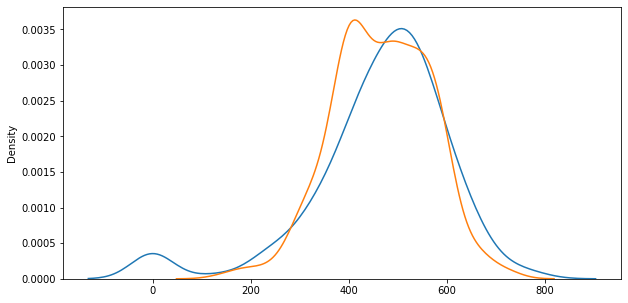

In [ ]:
# 결정계수가 0.5정도 밖에 되지않아 석식계는 신뢰도가 그리 크지 않다.
y_hat_dinner_0 = lr_dinner.predict(X_test_dinner)

plt.figure(figsize=(10,5))
ax1 = sns.distplot(y_test_dinner, hist=False, label='y_test')
ax2 = sns.distplot(y_hat_dinner_0, hist=False, label='y_hat', ax=ax1)
plt.show()
plt.close()

In [ ]:
# K-최근접이웃 학습모델
knn_dinner = KNeighborsClassifier(n_neighbors = 5)
knn_dinner.fit(X_train_dinner, y_train_dinner)

y_hat_dinner_1 = knn_dinner.predict(X_dinner_test)
y_hat_dinner_1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


array([  0., 407., 217., 458., 417., 336., 353., 265., 488., 449., 337.,
       633., 488., 339., 434., 265., 488., 486., 276., 461., 235., 488.,
         0., 423., 343., 400., 400.,   0., 434., 217., 595., 502., 335.,
       449., 217., 488., 486., 335., 361., 226., 489., 434.,   0., 353.,
       235., 488., 502., 335., 449., 135.])

In [ ]:
# 의사결정나무 학습모델
tree_model_dinner = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
tree_model_dinner.fit(X_train_dinner, y_train_dinner)

y_hat_dinner_2 = tree_model_dinner.predict(X_dinner_test)

print(y_hat_dinner_2)

In [ ]:
# 중식계는 신뢰도가 상당히 있는듯 하다.
X_train_lunch, X_test_lunch, y_train_lunch, y_test_lunch = train_test_split(X_lunch_cols, Y_lunch, test_size = 0.2, random_state = 10)
lr_lunch = LinearRegression()
lr_lunch.fit(X_train_lunch, y_train_lunch)

r_square_lunch = lr_lunch.score(X_test_lunch, y_test_lunch)
print("결정계수:", r_square_lunch)

결정계수: 0.8108565089863242


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


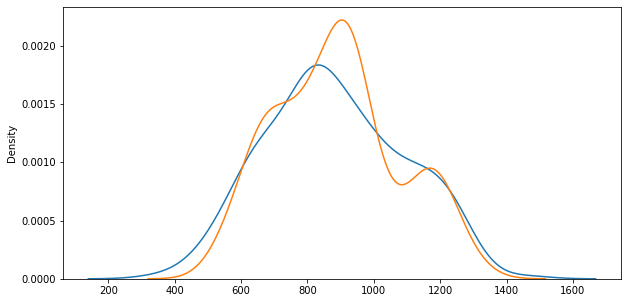

In [ ]:
y_hat_lunch_0 = lr_lunch.predict(X_test_lunch)

plt.figure(figsize=(10,5))
ax3 = sns.distplot(y_test_lunch, hist=False, label='y_test')
ax4 = sns.distplot(y_hat_lunch_0, hist=False, label='y_hat', ax=ax3)
plt.show()
plt.close()

In [ ]:
# K-최근접이웃 학습모델
knn_lunch = KNeighborsClassifier(n_neighbors = 5)
knn_lunch.fit(X_train_lunch, y_train_lunch)

y_hat_lunch_1 = knn_lunch.predict(X_lunch_test)
print(y_hat_lunch_1)

[ 778.  827.  579.  880.  839.  704.  653.  539.  911.  804.  514. 1138.
 1075.  831.  804.  516. 1075. 1075.  660.  804.  505.  911.  831.  781.
  620.  793.  793.  831.  761.  579. 1138.  781.  778.  823.  579.  911.
  781.  704.  662.  398.  911.  761.  704.  682.  505.  911.  781.  704.
  823.  383.]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# 의사결정나무 학습
tree_model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=5)
tree_model.fit(X_train_lunch, y_train_lunch)

y_hat_lunch_2 = tree_model.predict(X_lunch_test)

print(y_hat_lunch_2)

[ 924.  873.  924.  936. 1006. 1006.  953.  843.  936.  804.  776.  971.
  839. 1006.  924.  477. 1140.  839. 1006.  765.  477.  936. 1006.  953.
  843.  936. 1006.  953.  873.  924.  936.  839.  924.  873.  477.  936.
  924.  924.  843.  477.  936.  924.  924.  765.  477.  936. 1006.  924.
  873.  477.]


In [ ]:
# 중식계는 의사결정나무를 따르고, 석식계는 K-최근접이웃 학습모델을 따르기로 결정
y_hat_lunch_2 = pd.DataFrame(y_hat_lunch_2)
y_hat_dinner_1 = pd.DataFrame(y_hat_dinner_1)
submission["중식계"] = y_hat_lunch_2
submission["석식계"] = y_hat_dinner_1
# 최종결과를 submisson에 기입
submission.to_csv('/content/sample_submission.csv', index=False)